In [1]:
!pip install -q category_encoders imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import category_encoders as ce
import seaborn as sns


# Loading the dataset

In [3]:
path = "/content/cafc-open-gouv-database-2021-01-01-to-2025-09-30-extracted-2025-10-01.csv"
df = pd.read_csv(path, dtype=str)
df.head(5)


,Numéro d'identification / Number ID,Date Received / Date reçue,Complaint Received Type,Type de plainte reçue,Country,Pays,Province/State,Province/État,Fraud and Cybercrime Thematic Categories,Catégories thématiques sur la fraude et la cybercriminalité,...,Méthode de sollicitation,Gender,Genre,Language of Correspondence,Langue de correspondance,Victim Age Range / Tranche d'âge des victimes,Complaint Type,Type de plainte,Number of Victims / Nombre de victimes,Dollar Loss /pertes financières
0,350308,2025-09-29,Phone,Téléphone,Canada,Canada,Ontario,Ontario,Personal Info,Renseignements personnels,...,Appel direct,Female,Femme,English,Anglais,'30 - 39,Victim,Victime,1,$0.00
1,350309,2025-09-29,Phone,Téléphone,Canada,Canada,Quebec,Québec,Identity Fraud,Fraude à l'identité,...,Autre/inconnu,Male,Homme,English,Anglais,'50 - 59,Victim,Victime,1,$0.00
2,350310,2025-09-29,Phone,Téléphone,Canada,Canada,Quebec,Québec,Extortion,Extorsion,...,Appel direct,Female,Femme,French,Français,'20 - 29,Attempt,Tentative,0,$0.00
3,350311,2025-09-29,Phone,Téléphone,Canada,Canada,Ontario,Ontario,Identity Fraud,Fraude à l'identité,...,Autre/inconnu,Female,Femme,English,Anglais,'40 - 49,Victim,Victime,1,$0.00
4,350312,2025-09-29,Phone,Téléphone,Canada,Canada,Manitoba,Manitoba,Identity Fraud,Fraude à l'identité,...,Autre/inconnu,Female,Femme,English,Anglais,'60 - 69,Victim,Victime,1,$0.00


# Quick look & basic cleaning

In [4]:
df.shape, df.columns.tolist()

((350361, 21),
 ["Numéro d'identification / Number ID",
  'Date Received / Date reçue',
  'Complaint Received Type',
  'Type de plainte reçue',
  'Country',
  'Pays',
  'Province/State',
  'Province/État',
  'Fraud and Cybercrime Thematic Categories',
  'Catégories thématiques sur la fraude et la cybercriminalité',
  'Solicitation Method',
  'Méthode de sollicitation',
  'Gender',
  'Genre',
  'Language of Correspondence',
  'Langue de correspondance',
  "Victim Age Range / Tranche d'âge des victimes",
  'Complaint Type',
  'Type de plainte',
  'Number of Victims / Nombre de victimes',
  'Dollar Loss /pertes financières'])

#  renaming columns for convenience

In [7]:
cols_map = {
    "Numéro d'identification / Number ID": "case_id",
    'Date Received / Date reçue': 'date_received',
    'Complaint Received Type / Type de plainte reçue': 'complaint_type',
    'Country / Pays': 'country',
    'Province/State / Province/État': 'province',
    'Fraud and Cybercrime Thematic Categories / Catégories thématiques sur la fraude et la cybercriminalité': 'fraud_category',
    'Solicitation Method / Méthode de sollicitation': 'solicitation_method',
    'Gender / Genre': 'gender',
    'Language of Correspondence / Langue de correspondance': 'language',
    'Victim Age Range / Tranche d\'âge des victimes': 'age_range',
    'Complaint Type / Type de plainte': 'complaint_subtype',
    'Number of Victims / Nombre de victimes': 'num_victims',
    'Dollar Loss /pertes financières': 'dollar_loss'
}

available = {c:c for c in df.columns}
# Performing mapping for only columns that exist
mapped = {k:v for k,v in cols_map.items() if k in df.columns}
df = df.rename(columns=mapped)
# Showing columns after rename
df.columns.tolist()

['case_id',
 'date_received',
 'Complaint Received Type',
 'Type de plainte reçue',
 'Country',
 'Pays',
 'Province/State',
 'Province/État',
 'Fraud and Cybercrime Thematic Categories',
 'Catégories thématiques sur la fraude et la cybercriminalité',
 'Solicitation Method',
 'Méthode de sollicitation',
 'Gender',
 'Genre',
 'Language of Correspondence',
 'Langue de correspondance',
 'age_range',
 'Complaint Type',
 'Type de plainte',
 'num_victims',
 'dollar_loss']

In [9]:
df = df.rename(columns={
    'Province/State': 'province',
    'Fraud and Cybercrime Thematic Categories': 'fraud_category',
    'Solicitation Method': 'solicitation_method'
})


## Inspecting sample rows and specific fields

In [10]:
display(df[['case_id','date_received','province','fraud_category','solicitation_method','age_range','dollar_loss']].head(10))

,case_id,date_received,province,fraud_category,solicitation_method,age_range,dollar_loss
0,350308,2025-09-29,Ontario,Personal Info,Direct call,'30 - 39,$0.00
1,350309,2025-09-29,Quebec,Identity Fraud,Other/unknown,'50 - 59,$0.00
2,350310,2025-09-29,Quebec,Extortion,Direct call,'20 - 29,$0.00
3,350311,2025-09-29,Ontario,Identity Fraud,Other/unknown,'40 - 49,$0.00
4,350312,2025-09-29,Manitoba,Identity Fraud,Other/unknown,'60 - 69,$0.00
5,350313,2025-09-29,Alberta,Investments,Internet,'70 - 79,"$20,000.00"
6,350314,2025-09-29,Quebec,Identity Fraud,Not Available,'30 - 39,$0.00
7,350315,2025-09-29,New Brunswick,Personal Info,Other/unknown,'60 - 69,$0.00
8,350316,2025-09-29,Quebec,Unknown,Email,'60 - 69,$0.00
9,350317,2025-09-29,Quebec,Service,Internet,'20 - 29,$596.67


# Parse dollar_loss to numeric

In [11]:
def parse_dollar(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # removing $ and commas and other non-numeric characters
    s = re.sub(r'[^\d\.\-]', '', s)
    if s == '':
        return np.nan
    try:
        return float(s)
    except:
        return np.nan

df['dollar_loss_num'] = df['dollar_loss'].apply(parse_dollar)
df['dollar_loss_num'].describe()


,dollar_loss_num
count,3.503610e+05
mean,7.670432e+03
std,1.029056e+05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.361500e+07


In [12]:
# Creating binary target: loss_flag = 1 if dollar_loss_num > 0 else 0
df['loss_flag'] = df['dollar_loss_num'].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)
df['loss_flag'].value_counts(dropna=False)

,count
loss_flag,
0,263516
1,86845


# Extracting numeric age from age_range (use lower bound of range)

In [13]:
def age_to_num(s):
    if pd.isna(s):
        return np.nan
    s = str(s)
    # looking for first number, e.g., '30 - 39' or "'30 - 39"
    m = re.search(r'(\d{1,3})', s)
    if m:
        return int(m.group(1))
    return np.nan

df['age_lower'] = df['age_range'].apply(age_to_num)
df['age_lower'].describe()


,age_lower
count,245470.000000
mean,43.174131
std,18.597663
min,1.000000
25%,30.000000
50%,40.000000
75%,60.000000
max,100.000000


# Cleaning categorical fields (trim, fillna)

In [14]:
for c in ['province','fraud_category','solicitation_method','gender','language','complaint_subtype']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})


# Exploratory Data Analysis

Loss flag distribution:
 loss_flag
0    263516
1     86845
Name: count, dtype: int64


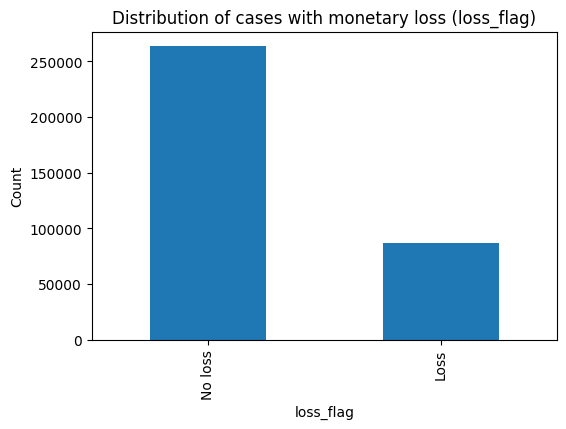

In [15]:
# Loss distribution
print("Loss flag distribution:\n", df['loss_flag'].value_counts())

plt.figure(figsize=(6,4))
df['loss_flag'].value_counts().plot(kind='bar')
plt.title('Distribution of cases with monetary loss (loss_flag)')
plt.xticks([0,1], ['No loss','Loss'])
plt.ylabel('Count')
plt.show()


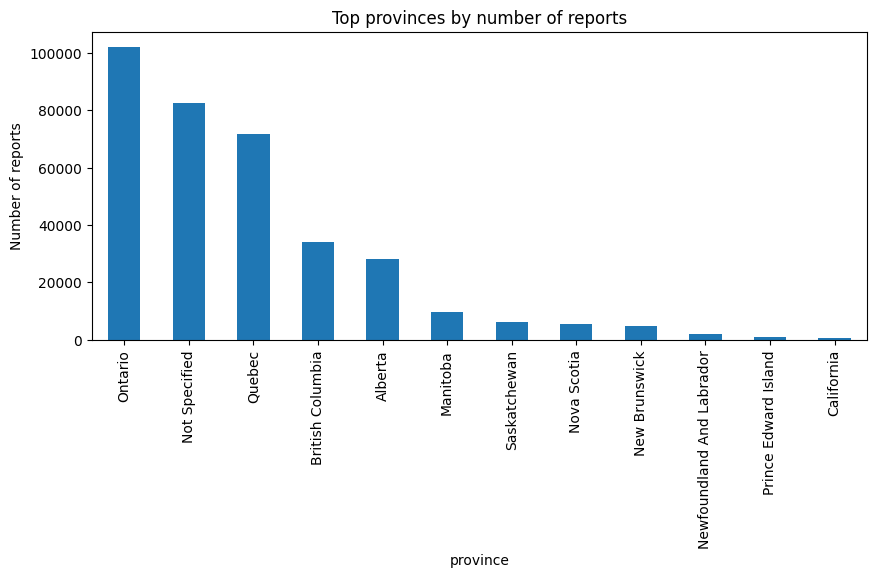

In [16]:
# Fraud by province (top 10)
if 'province' in df.columns:
    prov_counts = df[df['province'].notna()]['province'].value_counts().head(12)
    plt.figure(figsize=(10,4))
    prov_counts.plot(kind='bar')
    plt.title('Top provinces by number of reports')
    plt.ylabel('Number of reports')
    plt.show()


,count,sum,loss_rate
province,,,
Ontario,102210,25043,0.245015
Not Specified,82484,27733,0.336223
Quebec,71813,10228,0.142425
British Columbia,33958,8444,0.248660
Alberta,28044,7020,0.250321
Manitoba,9536,2672,0.280201
Saskatchewan,6219,1858,0.298762
Nova Scotia,5684,1188,0.209008
New Brunswick,4668,1016,0.217652


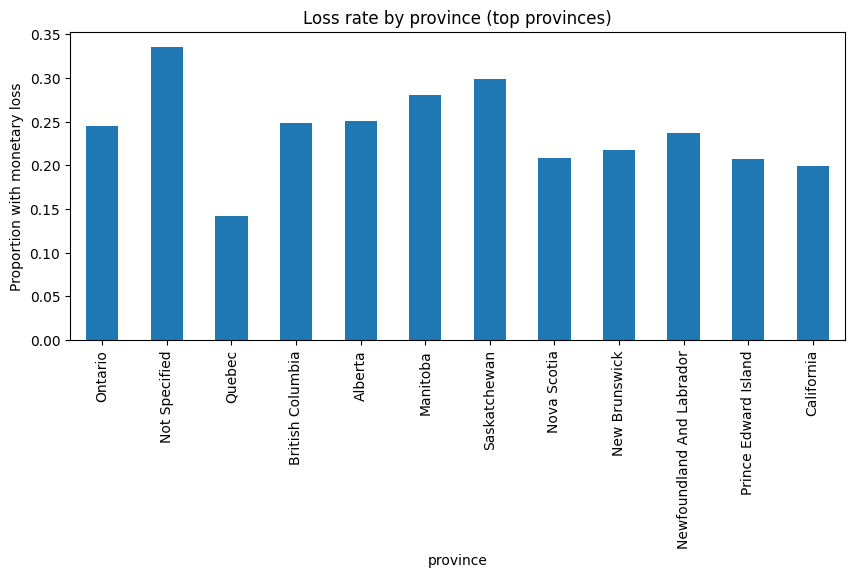

In [17]:
# Loss by province (proportion of cases with loss)
if 'province' in df.columns:
    prov_group = df.groupby('province')['loss_flag'].agg(['count','sum']).dropna().sort_values('count', ascending=False)
    prov_group['loss_rate'] = prov_group['sum'] / prov_group['count']
    display(prov_group.head(15))
    plt.figure(figsize=(10,4))
    prov_group['loss_rate'].head(12).plot(kind='bar')
    plt.ylabel('Proportion with monetary loss')
    plt.title('Loss rate by province (top provinces)')
    plt.show()


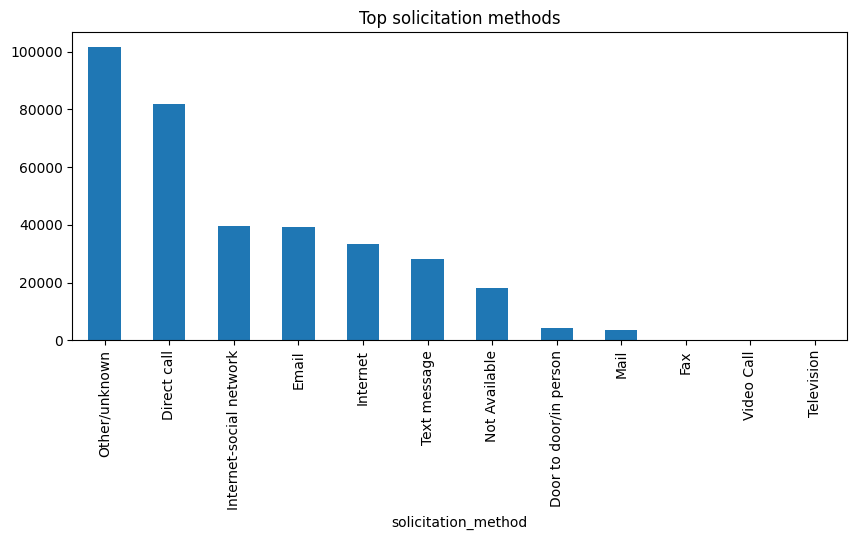

,count,sum,loss_rate
solicitation_method,,,
Other/unknown,101691,3869,0.038047
Direct call,81723,11361,0.139018
Internet-social network,39565,26598,0.672261
Email,39304,7032,0.178913
Internet,33356,20505,0.614732
Text message,28227,4262,0.150990
Not Available,18249,11568,0.633898
Door to door/in person,4330,1346,0.310855
Mail,3444,152,0.044135


In [20]:
# Solicitation methods
if 'solicitation_method' in df.columns:
    s_counts = df['solicitation_method'].value_counts().head(12)
    plt.figure(figsize=(10,4))
    s_counts.plot(kind='bar')
    plt.title('Top solicitation methods')
    plt.show()

    # Loss rate by solicitation method
    sm_group = df.groupby('solicitation_method')['loss_flag'].agg(['count','sum'])
    sm_group['loss_rate'] = sm_group['sum'] / sm_group['count']
    display(sm_group.sort_values('count', ascending=False).head(12))


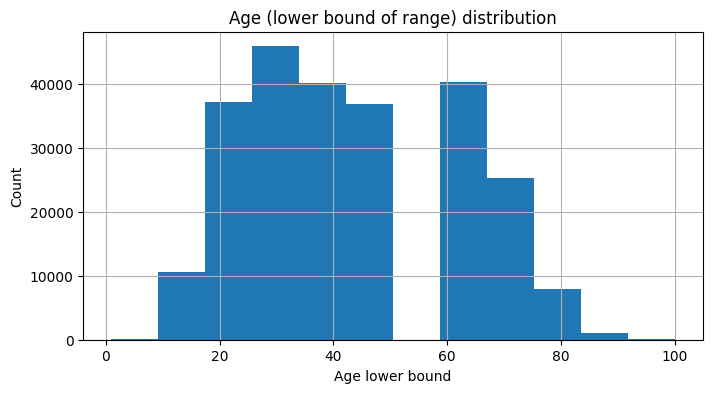

/tmp/ipython-input-319438563.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group = df.groupby(pd.cut(df['age_lower'], bins=[0,19,29,39,49,59,69,79,120]))['loss_flag'].agg(['count','sum'])


,count,sum,loss_rate
age_lower,,,
"(0, 19]",10803,1677,0.155235
"(19, 29]",37165,9508,0.255832
"(29, 39]",45888,9297,0.202602
"(39, 49]",40085,8519,0.212523
"(49, 59]",36854,8007,0.217263
"(59, 69]",40389,8633,0.213746
"(69, 79]",25233,5722,0.226767
"(79, 120]",9053,2092,0.231084


In [21]:
# Age distribution and loss rate by age
plt.figure(figsize=(8,4))
df['age_lower'].dropna().hist(bins=12)
plt.title('Age (lower bound of range) distribution')
plt.xlabel('Age lower bound')
plt.ylabel('Count')
plt.show()

age_group = df.groupby(pd.cut(df['age_lower'], bins=[0,19,29,39,49,59,69,79,120]))['loss_flag'].agg(['count','sum'])
age_group['loss_rate'] = age_group['sum']/age_group['count']
display(age_group)


# Preparing dataset for modeling

In [22]:
# Selecting a reasonable set of features
features = []
if 'province' in df.columns: features.append('province')
if 'fraud_category' in df.columns: features.append('fraud_category')
if 'solicitation_method' in df.columns: features.append('solicitation_method')
if 'gender' in df.columns: features.append('gender')
if 'language' in df.columns: features.append('language')
if 'age_lower' in df.columns: features.append('age_lower')
if 'num_victims' in df.columns:
    # converting num_victims to numeric
    df['num_victims_num'] = pd.to_numeric(df['num_victims'].str.replace(r'[^\d]', '' , regex=True), errors='coerce')
    features.append('num_victims_num')

print("Features used:", features)
model_df = df[features + ['loss_flag']].copy()
model_df = model_df.dropna(subset=['loss_flag'])
model_df = model_df.dropna(subset=['age_lower'], how='all')
model_df.shape


Features used: ['province', 'fraud_category', 'solicitation_method', 'age_lower', 'num_victims_num']


(245470, 6)

In [23]:
# Filling missing categorical with 'Unknown'
for c in features:
    if model_df[c].dtype == 'object':
        model_df[c] = model_df[c].fillna('Unknown')

model_df['age_lower'] = model_df['age_lower'].fillna(model_df['age_lower'].median())
model_df = model_df.reset_index(drop=True)
model_df['loss_flag'].value_counts()


,count
loss_flag,
0,192015
1,53455


In [24]:
# Encoding categorical features using TargetEncoder / OneHot depending on model.
cat_cols = [c for c in features if model_df[c].dtype == 'object']
num_cols = [c for c in features if c not in cat_cols]

cat_cols, num_cols

(['province', 'fraud_category', 'solicitation_method'],
 ['age_lower', 'num_victims_num'])

# Train/test spliting

In [25]:
X = model_df[features]
y = model_df['loss_flag'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (184102, 5) Test size: (61368, 5)


In [26]:
# checking imbalance
print("Train class distribution:\n", y_train.value_counts())

Train class distribution:
 loss_flag
0    144011
1     40091
Name: count, dtype: int64


# Model training

### Logistic Regression pipeline: One-hot encode categorical, scale

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preproc_lr = ColumnTransformer(transformers=[
    ('ohe', ohe, cat_cols),
    ('num', 'passthrough', num_cols)
])


pipe_lr = Pipeline(steps=[
    ('pre', preproc_lr),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

# Fitting logistic
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]


In [31]:
print("Logistic Regression classification report:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression classification report:
              precision    recall  f1-score   support

           0     0.9963    0.8812    0.9352     48004
           1     0.6984    0.9884    0.8185     13364

    accuracy                         0.9045     61368
   macro avg     0.8474    0.9348    0.8768     61368
weighted avg     0.9315    0.9045    0.9098     61368

ROC AUC: 0.9759504414739858


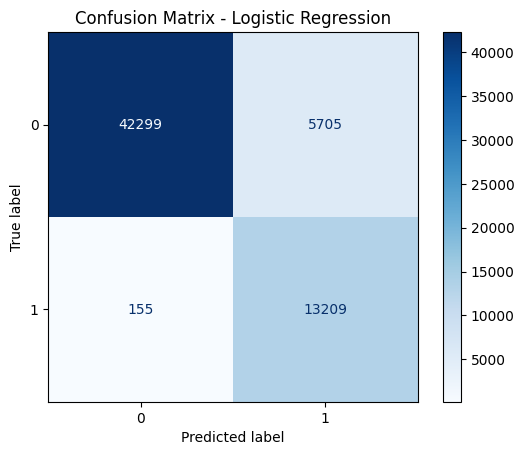

In [45]:
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


##  Decision Tree

In [32]:
# For tree-based models we can use ordinal encoding for categorical
encoder = ce.OrdinalEncoder(cols=cat_cols, handle_unknown='impute')
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=7)
dt.fit(X_train_enc, y_train)
y_pred_dt = dt.predict(X_test_enc)
y_proba_dt = dt.predict_proba(X_test_enc)[:,1]


In [33]:
print("Decision Tree classification report:")
print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

Decision Tree classification report:
              precision    recall  f1-score   support

           0     0.9921    0.9028    0.9453     48004
           1     0.7362    0.9740    0.8386     13364

    accuracy                         0.9183     61368
   macro avg     0.8641    0.9384    0.8919     61368
weighted avg     0.9363    0.9183    0.9221     61368

ROC AUC: 0.9738849856333681


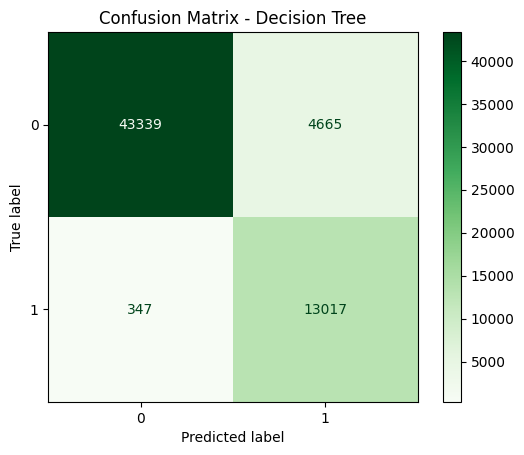

In [46]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot(cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

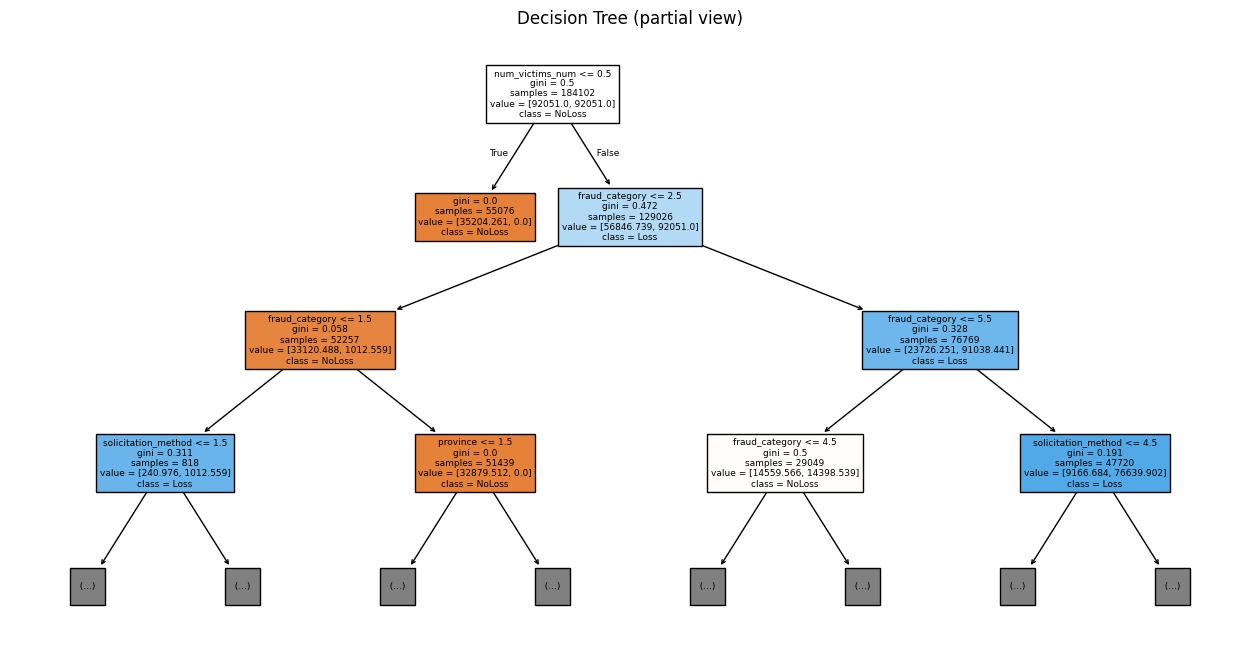

In [35]:
# Plot for decision tree
plt.figure(figsize=(16,8))
plot_tree(dt, feature_names=X_train_enc.columns, class_names=['NoLoss','Loss'], filled=True, max_depth=3)
plt.title("Decision Tree (partial view)")
plt.show()


## Random Forest

In [37]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)
y_proba_rf = rf.predict_proba(X_test_enc)[:,1]

In [38]:
print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest classification report:
              precision    recall  f1-score   support

           0     0.9852    0.9094    0.9458     48004
           1     0.7450    0.9508    0.8354     13364

    accuracy                         0.9184     61368
   macro avg     0.8651    0.9301    0.8906     61368
weighted avg     0.9329    0.9184    0.9217     61368

ROC AUC: 0.9734482656289168


## Feature importance for random forest

,0
fraud_category,0.403711
num_victims_num,0.302949
solicitation_method,0.252210
province,0.025221
age_lower,0.015909


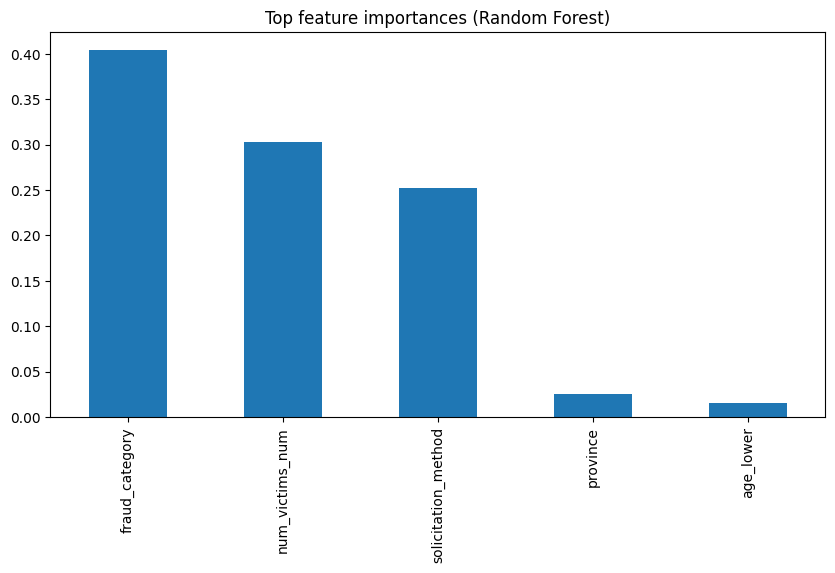

In [39]:
importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns).sort_values(ascending=False)
display(importances.head(20))

plt.figure(figsize=(10,5))
importances.head(15).plot(kind='bar')
plt.title('Top feature importances (Random Forest)')
plt.show()


# ROC curves comparison

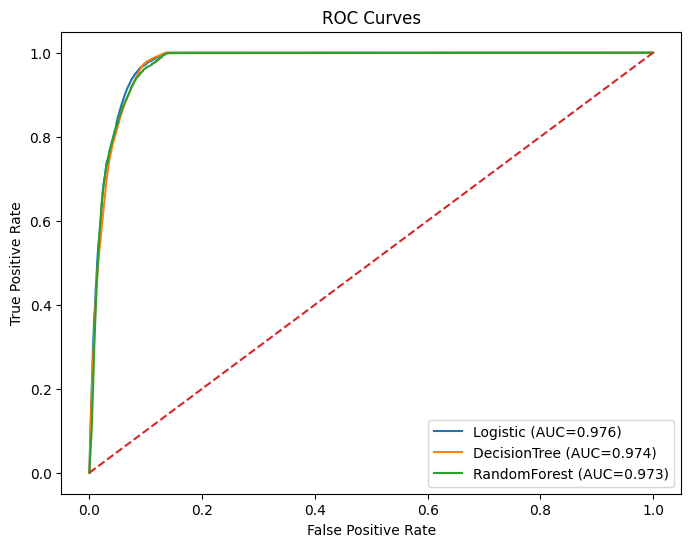

In [40]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={roc_auc_score(y_test,y_proba_lr):.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'DecisionTree (AUC={roc_auc_score(y_test,y_proba_dt):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_score(y_test,y_proba_rf):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


# Precision-Recall curve & average precision

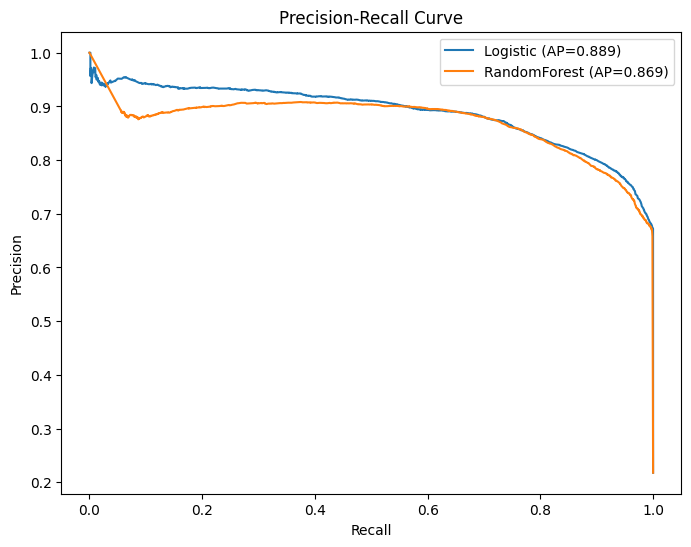

In [41]:
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(rec_lr, prec_lr, label=f'Logistic (AP={average_precision_score(y_test,y_proba_lr):.3f})')
plt.plot(rec_rf, prec_rf, label=f'RandomForest (AP={average_precision_score(y_test,y_proba_rf):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


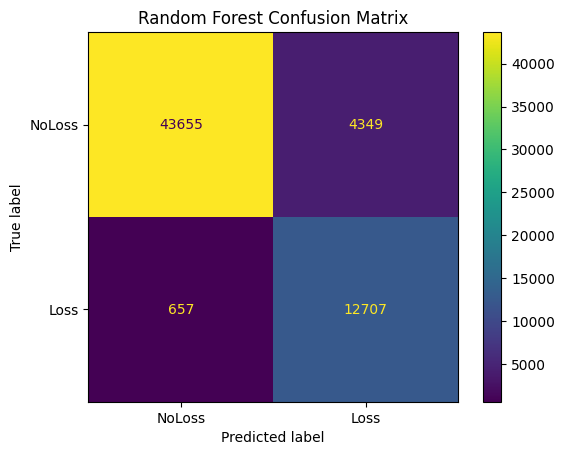

In [42]:
# Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=['NoLoss','Loss'])
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()


In [43]:
# hyperparameter grid search for RandomForest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
                  param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
gs.fit(X_train_enc, y_train)
print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)
best_rf = gs.best_estimator_
y_proba_best = best_rf.predict_proba(X_test_enc)[:,1]
print("Test ROC AUC (best RF):", roc_auc_score(y_test, y_proba_best))


Best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC AUC: 0.9759460712288656
Test ROC AUC (best RF): 0.9753328362078278


In [44]:
# Save best model and encoder
import joblib
joblib.dump(encoder, '/content/encoder.pkl')
joblib.dump(best_rf, '/content/best_rf.pkl')
print("Saved encoder and best_rf to /content/")


Saved encoder and best_rf to /content/
